In [1]:
import warnings
warnings.filterwarnings('ignore')

import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from scipy import stats
from sklearn.metrics import mean_squared_error

element_symbol = {
    6: 'C',
    7: 'N',
    8: 'O',
    9: 'F',
    15: 'P',
    16: 'S',
    17: 'Cl',
    35: 'Br',
    53: 'I'
}

In [2]:
%matplotlib inline
plt.style.use('fivethirtyeight')

plt.rcParams['axes.facecolor']='w'
#plt.rcParams['axes.linewidth']=1
plt.rcParams['axes.edgecolor']='w'
plt.rcParams['figure.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
#plt.rcParams['grid.color']='white'

In [4]:
rdkit_features = pd.read_csv('../data/pdbbind_2018_general_rdkit_features_clean.csv', index_col=0)
rfscore_features = pd.read_csv('../data/pdbbind_2018_general_rfscore_features_clean.csv', index_col=0)
nnscore_features = pd.read_csv('../data/pdbbind_2018_general_binana_features_clean.csv', index_col=0)
binding_data = pd.read_csv('../data/pdbbind_2018_general_binding_data_clean.csv', index_col=0, squeeze=True)
binding_data = binding_data.rename('pK')

# re-label RF-Score features to use element symbol instead of atomic number
rfscore_features = rfscore_features.rename(mapper = lambda f: element_symbol[int(f.split('.')[0])] + '-' + element_symbol[int(f.split('.')[1])], axis='columns')

all_features = pd.concat([rdkit_features, rfscore_features, nnscore_features], axis='columns')

feature_sets = {
    'Vina': pd.Index(['vina_gauss1', 'vina_gauss2', 'vina_hydrogen', 'vina_hydrophobic', 'vina_repulsion', 'num_rotors']),
    'RDKit': rdkit_features.columns,
    'RF-Score': rfscore_features.columns,
    'NNScore 2.0': nnscore_features.columns,
}

feature_sets['RF-Score v3'] = feature_sets['RF-Score'].union(feature_sets['Vina'])

for f in ['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']:
    feature_sets[f'{f} + RDKit'] = feature_sets[f].union(feature_sets['RDKit'])
    # Vina, and hence anything that includes its terms, already uses the number of rotatable bonds, so we drop the RDKit version
    if f != 'RF-Score':
        feature_sets[f'{f} + RDKit'] = feature_sets[f'{f} + RDKit'].drop(['NumRotatableBonds'])

core_sets = {}
for year in ['2007', '2013', '2016']:
    with open(f'../data/pdbbind_{year}_core_pdbs.txt') as f:
        core_sets[year] = sorted([l.strip() for l in f])
core_sets['all'] = [pdb for pdb in core_sets['2007']]
core_sets['all'] = core_sets['all'] + [pdb for pdb in core_sets['2013'] if pdb not in core_sets['all']]
core_sets['all'] = core_sets['all'] + [pdb for pdb in core_sets['2016'] if pdb not in core_sets['all']]

In [4]:
for c in core_sets:
    core_sets[c] = pd.Index(core_sets[c])
    core_sets[c] = core_sets[c].intersection(all_features.index)

In [5]:
test_sets = {c: pd.Index(core_sets[c], name=c).intersection(all_features.index) for c in core_sets}

test = pd.Index(core_sets['all'])
train = all_features.index.difference(test)

In [6]:
features = all_features.loc[train, feature_sets['RF-Score v3']]
targets = binding_data.loc[train]

In [7]:
binned = targets.apply(lambda x: int(x))

In [8]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

from xgboost import XGBRegressor

In [114]:
print('CV score: ', enet_estimator.best_score_**0.5)
for core_set in core_sets:
    idx = pd.Index(core_sets[core_set])
    X_test = all_features.loc[idx, feature_sets['RF-Score v3']]
    y_test = binding_data.loc[idx]
    pred = enet_estimator.predict(X_test)
    print(core_set, pearsonr(y_test, pred))

CV score:  0.5940475584613585
2007 (0.6224778877731882, 2.0449121872438422e-22)
2013 (0.6530821973102782, 2.92642944253726e-23)
2016 (0.6703153796664693, 9.255489403638568e-38)
all (0.6355869738080054, 9.34448028735596e-61)


In [125]:
nn_params = {
    'nn__hidden_layer_sizes': [(n,) for n in np.arange(5, 100, 5)],
    'nn__activation': ['tanh'],
    'nn__alpha': 10.0 ** -np.arange(1, 7),
    'nn__max_iter': [500, 1000],
}

cv =  StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(features, binned)
pipe = Pipeline([('scaler', StandardScaler()), ('nn', MLPRegressor())])
nn_estimator = RandomizedSearchCV(pipe, param_distributions=nn_params, cv=cv, refit=True, n_iter=100, n_jobs=32, verbose=10, random_state=42).fit(features, targets)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=32)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=32)]: Done   8 tasks      | elapsed:   12.6s
[Parallel(n_jobs=32)]: Done  21 tasks      | elapsed:   14.4s
[Parallel(n_jobs=32)]: Done  34 tasks      | elapsed:   18.6s
[Parallel(n_jobs=32)]: Done  49 tasks      | elapsed:   22.8s
[Parallel(n_jobs=32)]: Done  64 tasks      | elapsed:   26.7s
[Parallel(n_jobs=32)]: Done  81 tasks      | elapsed:   33.7s
[Parallel(n_jobs=32)]: Done  98 tasks      | elapsed:   39.4s
[Parallel(n_jobs=32)]: Done 117 tasks      | elapsed:   44.1s
[Parallel(n_jobs=32)]: Done 136 tasks      | elapsed:   52.1s
[Parallel(n_jobs=32)]: Done 157 tasks      | elapsed:   55.1s
[Parallel(n_jobs=32)]: Done 178 tasks      | elapsed:  1.0min
[Parallel(n_jobs=32)]: Done 201 tasks      | elapsed:  1.1min
[Parallel(n_jobs=32)]: Done 224 tasks      | elapsed:  1.3min
[Parallel(n_jobs=32)]: Done 249 tasks      | elapsed:  1.4min
[Parallel(n_jobs=32)]: Done 274 tasks      | elapsed:  

In [128]:
nn_estimator.best_params_

{'nn__max_iter': 1000,
 'nn__hidden_layer_sizes': (50,),
 'nn__alpha': 0.1,
 'nn__activation': 'tanh'}

In [9]:
estimators = {
    #'enet': ElasticNet(),
    'rf': RandomForestRegressor(),
    'svr': SVR(),
    'nn': MLPRegressor(),
    'ab': AdaBoostRegressor(),
    'gb': GradientBoostingRegressor(),
    'xgb': XGBRegressor()
}

params = {
    'enet': {
        'enet__l1_ratio': [.1, .5, .7, .9, .95, .99, 1],
        'enet__alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    },
    'rf': {
        'rf__n_estimators': np.arange(50, 1050, 50),
        'rf__max_features': np.arange(0.1, 1.0, 0.1)
    },
    'svr': {
        'svr__kernel': ['linear', 'rbf'],
        'svr__C': 10.0 ** -np.arange(-3, 3),
        'svr__gamma': 10.0 ** -np.arange(-3, 3)
    },
    'nn': {
        'nn__hidden_layer_sizes': [(n,) for n in np.arange(5, 200, 5)],
        'nn__activation': ['tanh'],
        'nn__alpha': 10.0 ** -np.arange(1, 7),
        'nn__max_iter': [500, 1000]
    },
    'ab': {
        'ab__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
        'ab__n_estimators':  np.arange(50, 550, 50),
    },
    'gb': {
        'gb__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
        'gb__max_depth': np.arange(1, 11, 2),
        'gb__n_estimators': np.arange(50, 550, 50),
        'gb__subsample': [0.5, 1]
    },
    'xgb': {
        'xgb__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
        'xgb__max_depth': np.arange(1, 11, 2),
        'xgb__n_estimators': np.arange(50, 550, 50),
        'xgb__subsample': [0.5, 1]
    }
}

In [155]:
best_params = {}
cv_scores = {}
test_score = {}

for f in feature_sets:
    
    print(f'Using {f} features...')
    
    features = all_features.loc[train, feature_sets[f]]
    
    best_params[f] = {}
    cv_scores[f] = {}
    test_score[f] = {}
    
    for e in estimators:
        # sweep SVM separately due to O(d^3) complexity
        if e == 'svr':
            continue
        print(f'\tRandom search optimisation for {e} estimator...')
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(features, binned)
        pipe = Pipeline([('scaler', StandardScaler()), (e, estimators[e])])
        model = RandomizedSearchCV(pipe, param_distributions=params[e], cv=cv, refit=True, iid='False', n_iter=100, n_jobs=64, verbose=0, random_state=42).fit(features, targets)
        #cv_score[e] = model.best_score_

        # get pearson correlation for each cv fold
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(features, binned)
        scores = cross_val_score(model.best_estimator_, features, targets, cv=cv)
        cv_scores[f][e] = [s**0.5 for s in scores] # convert r-squared to pearsonr

        best_params[f][e] = model.best_params_
        test_score[f][e] = {}
        for core_set in core_sets:
            idx = pd.Index(core_sets[core_set])
            X_test = all_features.loc[idx, feature_sets[f]]
            y_test = binding_data.loc[idx]
            pred = model.predict(X_test)
            rp = pearsonr(y_test, pred)
            test_score[f][e][core_set] = rp

Using Vina features...
	Random search optimisation for enet estimator...
	Random search optimisation for rf estimator...
	Random search optimisation for nn estimator...
	Random search optimisation for ab estimator...
	Random search optimisation for gb estimator...
	Random search optimisation for xgb estimator...
Using RDKit features...
	Random search optimisation for enet estimator...
	Random search optimisation for rf estimator...
	Random search optimisation for nn estimator...
	Random search optimisation for ab estimator...
	Random search optimisation for gb estimator...
	Random search optimisation for xgb estimator...
Using RF-Score features...
	Random search optimisation for enet estimator...
	Random search optimisation for rf estimator...
	Random search optimisation for nn estimator...
	Random search optimisation for ab estimator...
	Random search optimisation for gb estimator...
	Random search optimisation for xgb estimator...
Using NNScore 2.0 features...
	Random search optimisa

In [10]:
# JSON encoder for np.int64
def default(o):
    if isinstance(o, np.integer):
        return int(o)
    raise TypeError    

In [164]:
with open('../results/random_search_best_params.json', 'w') as f:
    json.dump(best_params, f, default=default)
    
with open('../results/random_search_best_cv_scores.json', 'w') as f:
    json.dump(cv_scores, f, default=default) 

In [11]:
with open('../results/random_search_best_cv_scores.json') as f:
    cv_scores = json.load(f)

In [12]:
mean_cv_score = {f: {e: np.mean(cv_scores[f][e]) for e in cv_scores[f]} for f in cv_scores}

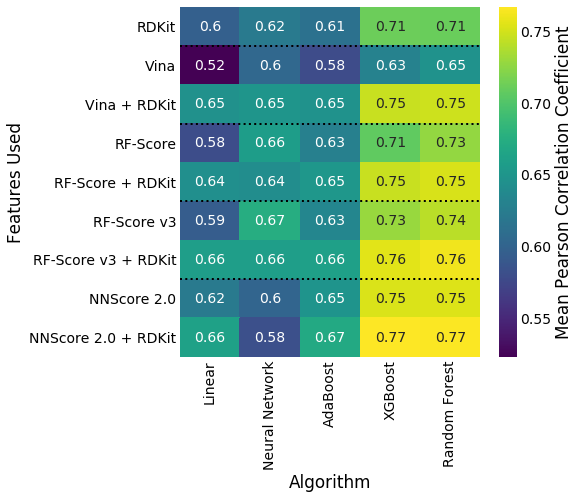

In [35]:
row_order = ['RDKit', 'Vina', 'Vina + RDKit', 'RF-Score', 'RF-Score + RDKit', 'RF-Score v3', 'RF-Score v3 + RDKit', 'NNScore 2.0', 'NNScore 2.0 + RDKit']
column_order = ['Linear', 'Neural Network', 'AdaBoost', 'Gradient Boosting', 'XGBoost', 'Random Forest']
mapper = {
    'enet': 'Linear',
    'ab': 'AdaBoost',
    'gb': 'Gradient Boosting',
    'xgb': 'XGBoost',
    'rf': 'Random Forest',
    'nn': 'Neural Network',
}
df = pd.DataFrame(mean_cv_score).T
df = df.rename(mapper=mapper, axis='columns')
df = df.loc[row_order, column_order]
df = df.drop('Gradient Boosting', axis='columns')

fig, ax = plt.subplots(1,1,figsize=(6,6))
sns.heatmap(df, annot=True, cmap='viridis', cbar_kws={'label': r"Mean Pearson Correlation Coefficient"}, ax=ax)
ax.set_xlabel('Algorithm')
ax.set_ylabel('Features Used')
ax.hlines([1, 3, 5, 7], *ax.get_xlim(), linestyle=':', linewidth=2)
fig.savefig('../figures/algorithm_comparison.jpg', dpi=350, bbox_inches='tight')

In [28]:
test_dfs = {}
for c in core_sets:
    results = {f: {e: np.mean(test_score[f][e][c]) for e in test_score[f]} for f in test_score}
    df = pd.DataFrame(mean_cv_score).T
    df = df.rename(mapper=mapper, axis='columns')
    df = df.loc[row_order, column_order]
    test_dfs[c] = df

NameError: name 'test_score' is not defined

In [29]:
rf_oob_n_estimators = {}
rf_val_n_estimators = {}

features = all_features.loc[train]
targets = binding_data.loc[train]
binned = targets.apply(lambda x: int(x/2))

# 80-20 train-validation split with stratifiication on binned pK values
features_train, features_test, y_train, y_test = train_test_split(features, targets, train_size=0.8, stratify=binned)

for f in feature_sets:
    X_train = features_train.loc[:,feature_sets[f]]
    X_test = features_test.loc[:, feature_sets[f]]
    oob = []
    val = []
    for n in np.arange(50, 1050, 50):
        rf = RandomForestRegressor(n_estimators=n, max_features=0.33, random_state=42, n_jobs=64, oob_score=True)
        rf.fit(X_train, y_train)
        oob.append(rf.oob_score_**0.5)
        val.append(stats.pearsonr(y_test, rf.predict(X_test))[0])
    rf_oob_n_estimators[f] = pd.Series(data=oob, index=np.arange(50, 1050, 50))
    rf_val_n_estimators[f] = pd.Series(data=val, index=np.arange(50, 1050, 50))

In [30]:
rf_oob_max_features = {}
rf_val_max_features = {}

features = all_features.loc[train]
targets = binding_data.loc[train]
binned = targets.apply(lambda x: int(x/2))

# 80-20 train-validation split with stratifiication on binned pK values
features_train, features_test, y_train, y_test = train_test_split(features, targets, train_size=0.8, stratify=binned)

for f in feature_sets:
    X_train = features_train.loc[:,feature_sets[f]]
    X_test = features_test.loc[:, feature_sets[f]]
    oob = []
    val = []
    for n in np.arange(0.05, 1.05, 0.05):
        rf = RandomForestRegressor(n_estimators=500, max_features=n, random_state=42, n_jobs=64, oob_score=True)
        rf.fit(X_train, y_train)
        oob.append(rf.oob_score_**0.5)
        val.append(stats.pearsonr(y_test, rf.predict(X_test))[0])
    rf_oob_max_features[f] = pd.Series(data=oob, index=np.arange(0.05, 1.05, 0.05))
    rf_val_max_features[f] = pd.Series(data=val, index=np.arange(0.05, 1.05, 0.05))

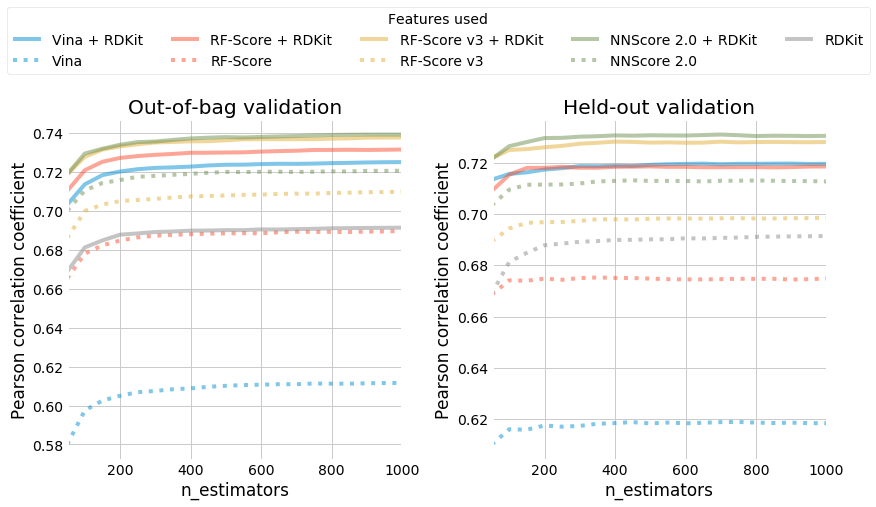

In [32]:
fig, ax = plt.subplots(1,2,figsize=(12,6))#, sharex=True, sharey=True)

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for f in ['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']:
    colour = next(colours)
    rf_oob_n_estimators[f'{f} + RDKit'].plot(ax=ax[0], color=colour, alpha=0.5, label=f'{f} + RDKit')
    rf_oob_n_estimators[f].plot(ax=ax[0], color=colour, label=f, alpha=0.5, linestyle=':')
colour = next(colours)
rf_oob_n_estimators['RDKit'].plot(ax=ax[0], color=colour, alpha=0.5, label='RDKit')
ax[0].set_xlabel('n_estimators')
ax[0].set_ylabel('Pearson correlation coefficient')
ax[0].set_title('Out-of-bag validation')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for f in ['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']:
    colour = next(colours)
    rf_val_n_estimators[f'{f} + RDKit'].plot(ax=ax[1], color=colour, alpha=0.5, label=f'{f} + RDKit')
    rf_val_n_estimators[f].plot(ax=ax[1], color=colour, label=f, alpha=0.5, linestyle=':')
colour = next(colours)
rf_oob_n_estimators['RDKit'].plot(ax=ax[1], color=colour, alpha=0.5, label='RDKit', linestyle=':')
ax[1].set_xlabel('n_estimators')
ax[1].set_ylabel('Pearson correlation coefficient')
ax[1].set_title('Held-out validation')

fig.tight_layout()

ax[0].legend(loc='upper left', bbox_to_anchor=(-0.2, 1.35),ncol=5, title='Features used')
fig.savefig('../figures/pdbbind_2018_refined_validation_n_estimators.jpg', dpi=350, bbox_inches='tight')

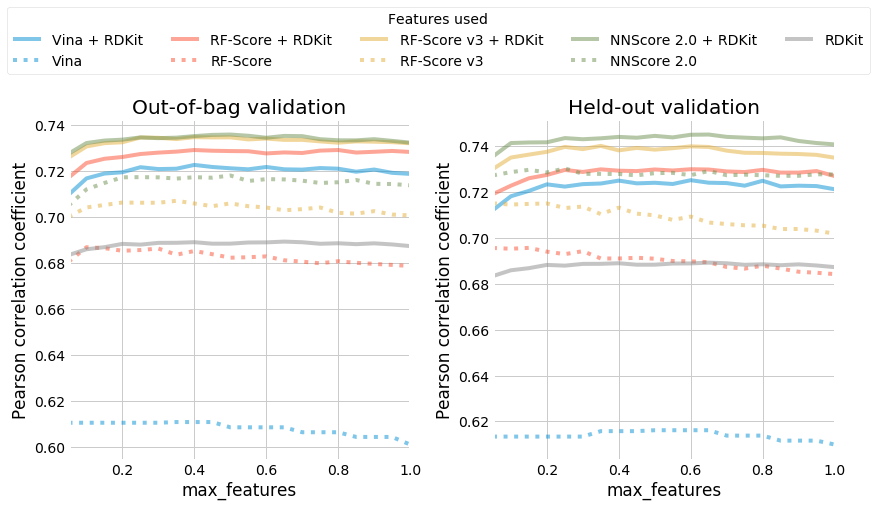

In [33]:
fig, ax = plt.subplots(1,2,figsize=(12,6))

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for f in ['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']:
    colour = next(colours)
    rf_oob_max_features[f'{f} + RDKit'].plot(ax=ax[0], color=colour, alpha=0.5, label=f'{f} + RDKit')
    rf_oob_max_features[f].plot(ax=ax[0], color=colour, label=f, alpha=0.5, linestyle=':')
colour = next(colours)
rf_oob_max_features['RDKit'].plot(ax=ax[0], color=colour, alpha=0.5, label='RDKit')
ax[0].set_xlabel('max_features')
ax[0].set_ylabel('Pearson correlation coefficient')
ax[0].set_title('Out-of-bag validation')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'][:5])

for f in ['Vina', 'RF-Score', 'RF-Score v3', 'NNScore 2.0']:
    colour = next(colours)
    rf_val_max_features[f'{f} + RDKit'].plot(ax=ax[1], color=colour, alpha=0.5, label=f'{f} + RDKit')
    rf_val_max_features[f].plot(ax=ax[1], color=colour, label=f, alpha=0.5, linestyle=':')
colour = next(colours)
rf_oob_max_features['RDKit'].plot(ax=ax[1], color=colour, alpha=0.5, label='RDKit')
ax[1].set_xlabel('max_features')
ax[1].set_ylabel('Pearson correlation coefficient')
ax[1].set_title('Held-out validation')

fig.tight_layout()

ax[0].legend(loc='upper left', bbox_to_anchor=(-0.2, 1.35),ncol=5, title='Features used')
fig.savefig('../figures/pdbbind_2018_refined_validation_max_features.jpg', dpi=350, bbox_inches='tight')

In [268]:
best_params['NNScore 2.0 + RDKit']['xgb']

{'xgb__subsample': 1,
 'xgb__n_estimators': 450,
 'xgb__max_depth': 7,
 'xgb__learning_rate': 0.1}

In [272]:
xgb_params = {
    'xgb__learning_rate': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    'xgb__max_depth': np.arange(1, 8, 1),
    'xgb__n_estimators': np.arange(50, 550, 50),
    'xgb__subsample': [0.5, 1],
    'xgb__reg_alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5],
    'xgb__reg_lambda': [0.01, 0.1, 1, 5, 10, 50]
}


xgb_best_params = {}
xgb_cv_scores = {}

for f in feature_sets:
    
    print(f'Using {f} features...')
    
    features = all_features.loc[train, feature_sets[f]]
    
    xgb_best_params[f] = {}
    xgb_cv_scores[f] = {}

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(features, binned)
    pipe = Pipeline([('scaler', StandardScaler()), ('xgb', XGBRegressor())])
    model = RandomizedSearchCV(pipe, param_distributions=params[e], cv=cv, refit=True, iid='False', n_iter=500, n_jobs=64, verbose=1, random_state=42).fit(features, targets)
    #cv_score[e] = model.best_score_

    # get pearson correlation for each cv fold
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(features, binned)
    scores = cross_val_score(model.best_estimator_, features, targets, cv=cv)
    xgb_cv_scores[f] = [s**0.5 for s in scores] # convert r-squared to pearsonr
    xgb_best_params[f][e] = model.best_params_

Using Vina features...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   20.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   26.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   33.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   41.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   53.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  1.1min
[Parallel(n_jobs=64)]: Done 2500 out of 2500 | elapsed:  1.2min finished


Using RDKit features...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   17.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:  1.4min
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  2.7min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  4.3min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  6.3min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  8.9min
[Parallel(n_jobs=64)]: Done 2500 out of 2500 | elapsed:  9.8min finished


Using RF-Score features...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    5.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   24.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   44.6s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  1.2min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  1.7min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  2.5min
[Parallel(n_jobs=64)]: Done 2500 out of 2500 | elapsed:  2.7min finished


Using NNScore 2.0 features...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   19.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  2.8min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  4.6min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  6.7min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  9.5min
[Parallel(n_jobs=64)]: Done 2500 out of 2500 | elapsed: 10.4min finished


Using RF-Score v3 features...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    7.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:   29.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:   55.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  1.5min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:  3.1min
[Parallel(n_jobs=64)]: Done 2500 out of 2500 | elapsed:  3.4min finished


Using Vina + RDKit features...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   24.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  3.5min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  5.8min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  8.3min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed: 11.7min
[Parallel(n_jobs=64)]: Done 2500 out of 2500 | elapsed: 12.7min finished


Using RF-Score + RDKit features...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   26.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:  2.2min
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  4.0min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  6.3min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  9.1min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed: 12.8min
[Parallel(n_jobs=64)]: Done 2500 out of 2500 | elapsed: 14.0min finished


Using RF-Score v3 + RDKit features...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   25.3s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:  1.9min
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  3.7min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  5.9min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:  8.7min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed: 12.6min
[Parallel(n_jobs=64)]: Done 2500 out of 2500 | elapsed: 13.9min finished


Using NNScore 2.0 + RDKit features...
Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=64)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:   55.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:  3.4min
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:  6.2min
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:  9.9min
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed: 14.4min
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed: 20.3min
[Parallel(n_jobs=64)]: Done 2500 out of 2500 | elapsed: 22.3min finished


In [38]:
xgb_params = {'subsample': 0.5, 'n_estimators': 500, 'max_depth': 7, 'learning_rate': 0.01}

xgb_test_scores = {}
xgb_cv_scores = {}

for f in feature_sets:
    
    print(f'Using {f} features...')
    
    xgb_test_scores[f] = {}
        
    X_train = all_features.loc[train, feature_sets[f]]
    y_train = binding_data.loc[train]
    binned = y_train.apply(lambda x: int(x))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_train, binned)
    
    xgb = XGBRegressor(**xgb_params, n_jobs=64, random_state=42)
    scores = cross_val_score(xgb, X_train, y_train, cv=cv)
    xgb_cv_scores[f] = [s**0.5 for s in scores] # convert r-squared to pearsonr

    xgb.fit(X_train, y_train)
    
    for t in test_sets:
        
        X_test = all_features.loc[test_sets[t], feature_sets[f]]
        y_test = binding_data.loc[test_sets[t]]
        pred = xgb.predict(X_test)
        rp = stats.pearsonr(y_test, pred)[0]
        xgb_test_scores[f][t] = rp

Using Vina features...
Using RDKit features...
Using RF-Score features...
Using NNScore 2.0 features...
Using RF-Score v3 features...
Using Vina + RDKit features...
Using RF-Score + RDKit features...
Using RF-Score v3 + RDKit features...
Using NNScore 2.0 + RDKit features...


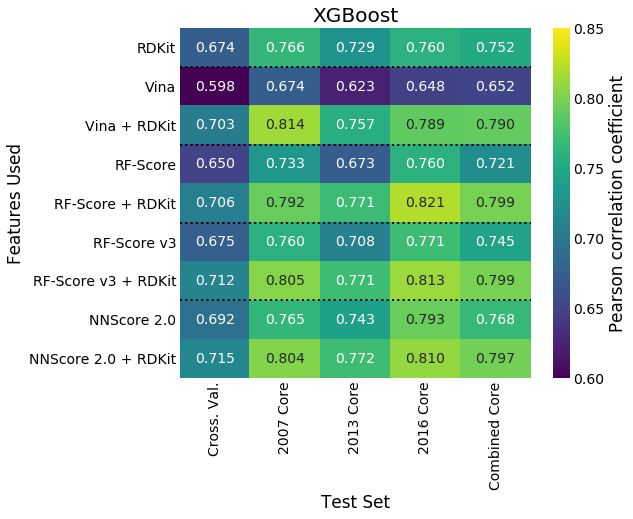

In [42]:
row_order = ['RDKit', 'Vina', 'Vina + RDKit', 'RF-Score', 'RF-Score + RDKit', 'RF-Score v3', 'RF-Score v3 + RDKit', 'NNScore 2.0', 'NNScore 2.0 + RDKit']
column_order = ['Cross. Val.', '2007 Core', '2013 Core', '2016 Core', 'Combined Core']
mapper = {
    '2007': '2007 Core',
    '2013': '2013 Core',
    '2016': '2016 Core',
    'all': 'Combined Core',
}

df = pd.DataFrame(xgb_test_scores).T
df = df.rename(mapper=mapper, axis='columns')
xgb_mean_cv_score = {f: np.mean(xgb_cv_scores[f]) for f in xgb_cv_scores}
xgb_mean_cv_score = pd.Series(xgb_mean_cv_score)
df['Cross. Val.'] = xgb_mean_cv_score.loc[df.index]
df = df.loc[row_order, column_order]
fig, ax = plt.subplots(1,1,figsize=(7, 6))
sns.heatmap(df, cmap='viridis', annot=True, fmt='.3f', vmin=0.6, vmax=0.85, ax=ax, cbar_kws={'label': 'Pearson correlation coefficient'})
ax.hlines([1, 3, 5, 7], *ax.get_xlim(), linestyle=':', linewidth=2)
ax.set_xlabel('Test Set')
ax.set_ylabel('Features Used')
ax.set_title('XGBoost')
fig.savefig('../figures/xgboost_performance_summary.jpg', dpi=350, bbox_inches='tight')

In [40]:
rf_params = {'n_estimators': 500, 'max_features': 0.33}

rf_cv_scores = {}
rf_test_scores = {}

for f in feature_sets:
    
    print(f'Using {f} features...')
    
    rf_test_scores[f] = {}
        
    X_train = all_features.loc[train, feature_sets[f]]
    y_train = binding_data.loc[train]
    binned = y_train.apply(lambda x: int(x))
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42).split(X_train, binned)
    
    rf = RandomForestRegressor(**rf_params, n_jobs=64, random_state=42)
    scores = cross_val_score(rf, X_train, y_train, cv=cv)
    rf_cv_scores[f] = [s**0.5 for s in scores] # convert r-squared to pearsonr

    rf.fit(X_train, y_train)
    
    for t in test_sets:
        
        X_test = all_features.loc[test_sets[t], feature_sets[f]]
        y_test = binding_data.loc[test_sets[t]]
        pred = rf.predict(X_test)
        rp = stats.pearsonr(y_test, pred)[0]
        rf_test_scores[f][t] = rp

Using Vina features...
Using RDKit features...
Using RF-Score features...
Using NNScore 2.0 features...
Using RF-Score v3 features...
Using Vina + RDKit features...
Using RF-Score + RDKit features...
Using RF-Score v3 + RDKit features...
Using NNScore 2.0 + RDKit features...


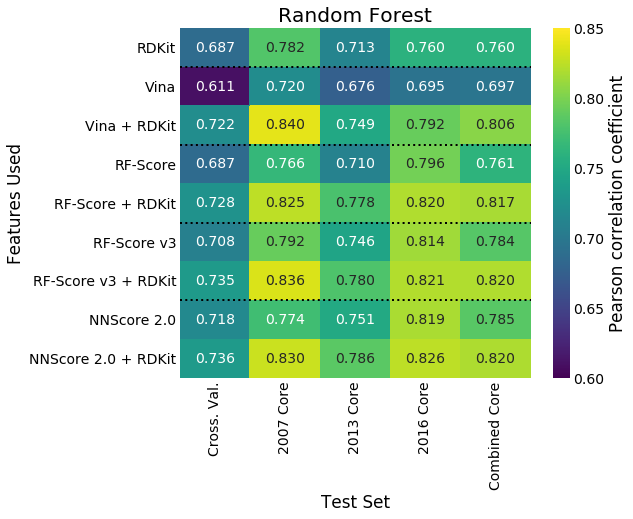

In [43]:
row_order = ['RDKit', 'Vina', 'Vina + RDKit', 'RF-Score', 'RF-Score + RDKit', 'RF-Score v3', 'RF-Score v3 + RDKit', 'NNScore 2.0', 'NNScore 2.0 + RDKit']
column_order = ['Cross. Val.', '2007 Core', '2013 Core', '2016 Core', 'Combined Core']
mapper = {
    '2007': '2007 Core',
    '2013': '2013 Core',
    '2016': '2016 Core',
    'all': 'Combined Core',
}

df = pd.DataFrame(rf_test_scores).T
df = df.rename(mapper=mapper, axis='columns')
rf_mean_cv_score = {f: np.mean(rf_cv_scores[f]) for f in rf_cv_scores}
rf_mean_cv_score = pd.Series(rf_mean_cv_score)
df['Cross. Val.'] = rf_mean_cv_score.loc[df.index]
df = df.loc[row_order, column_order]
fig, ax = plt.subplots(1,1,figsize=(7, 6))
sns.heatmap(df, cmap='viridis', annot=True, fmt='.3f', vmin=0.6, vmax=0.85, ax=ax, cbar_kws={'label': 'Pearson correlation coefficient'})
ax.hlines([1, 3, 5, 7], *ax.get_xlim(), linestyle=':', linewidth=2)
ax.set_xlabel('Test Set')
ax.set_ylabel('Features Used')
ax.set_title('Random Forest')
fig.savefig('../figures/rf_performance_summary.jpg', dpi=350, bbox_inches='tight')